In [1]:
# import the necessary packages

import cv2
import os
import sys
import csv
import pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
from CK import SmallVGGNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint

print('done!')

Using TensorFlow backend.


done!


In [3]:
lines = []

In [4]:
images =[]

In [5]:
labels=[]

In [6]:
with open('one-indexed-files-notrash_train2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [7]:
reader.line_num

1104

In [8]:
len(lines)

1104

In [9]:
lines[99]

['glass222.jpg', '1']

In [10]:
for line in lines:
    source_path=line[0]
    filename = source_path.split('\\')[-1]
    current_path='img/' + filename
    #print(current_path)
    img=cv2.imread(current_path)
    img=cv2.resize(img,(64,64))
    #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(line[1])

    

In [11]:
images[1][1][1]

array([237, 220, 217], dtype=uint8)

In [12]:
images[0].shape


(64, 64, 3)

In [13]:
lines[0]

['glass189.jpg', '1']

In [14]:
labels[0]

'1'

In [15]:
images[0][0][0]

array([155, 164, 174], dtype=uint8)

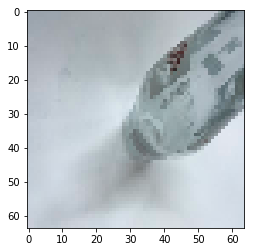

In [16]:
plt.imshow(images[0])

In [17]:
data = np.array(images, dtype="float") / 255.0
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data ,labels, test_size=0.20, random_state=42)

In [18]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [18]:
# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))

In [22]:
# initialize our initial learning rate, # of epochs to train for,
# and batch size
INIT_LR = 0.01
EPOCHS = 50
BS = 32

In [20]:
# initialize the model and optimizer (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt , metrics=["accuracy"])

[INFO] training network...


In [21]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [22]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [23]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max' , save_weights_only=True)
callbacks_list = [checkpoint]
# Fit the model

In [24]:
# train the network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // BS, epochs=EPOCHS, callbacks= callbacks_list )
#model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 1/50
27/27 [==============================] - 89s 3s/step - loss: 1.1045 - acc: 0.5986 - val_loss: 1.3205 - val_acc: 0.5385

Epoch 00003: saving model to weights-improvement-03-0.54.hdf5
Epoch 4/50
27/27 [==============================] - 90s 3s/step - loss: 0.9967 - acc: 0.6028 - val_loss: 1.7202 - val_acc: 0.4570

Epoch 00004: saving model to weights-improvement-04-0.46.hdf5
Epoch 5/50
27/27 [==============================] - 89s 3s/step - loss: 0.9610 - acc: 0.6345 - val_loss: 0.7300 - val_acc: 0.6968

Epoch 00005: saving model to weights-improvement-05-0.70.hdf5
Epoch 6/50
27/27 [==============================] - 89s 3s/step - loss: 0.8272 - acc: 0.6723 - val_loss: 3.3009 - val_acc: 0.4751

Epoch 00006: saving model to weights-improvement-06-0.48.hdf5
Epoch 7/50
27/27 [==============================] - 89s 3s/step - loss: 0.7030 - acc: 0.7294 - val_loss: 2.2391 - val_acc: 0.4932

Epoch 00007: saving model to weights-improvement-07-0.49.hdf5
Epoch 8/50
27/27 [=================

[INFO] evaluating network...
[INFO] serializing network and label binarizer...


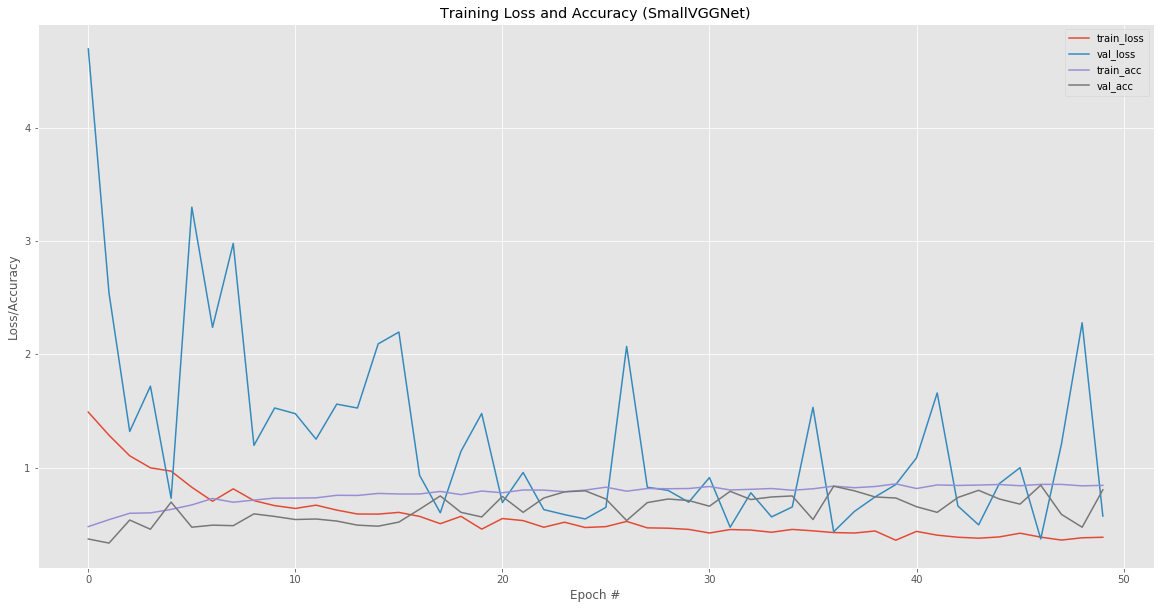

In [25]:

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY,predictions, target_names=lb.classes_))

# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot1")

# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("model_1")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

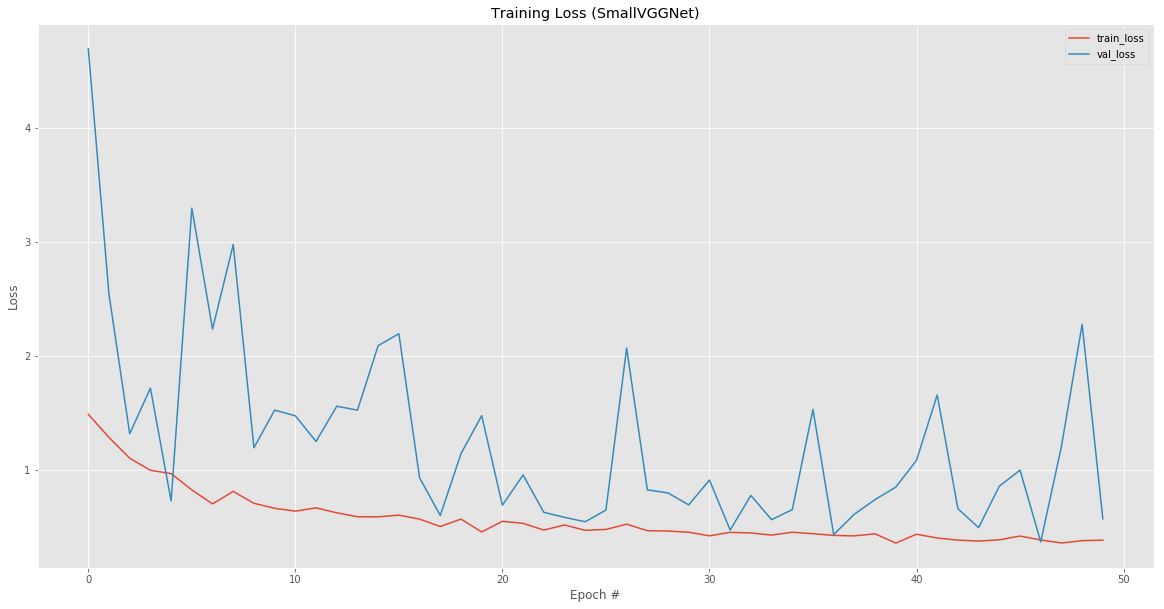

In [26]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.plot(N, H.history["acc"], label="train_acc")
#plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("plot2")

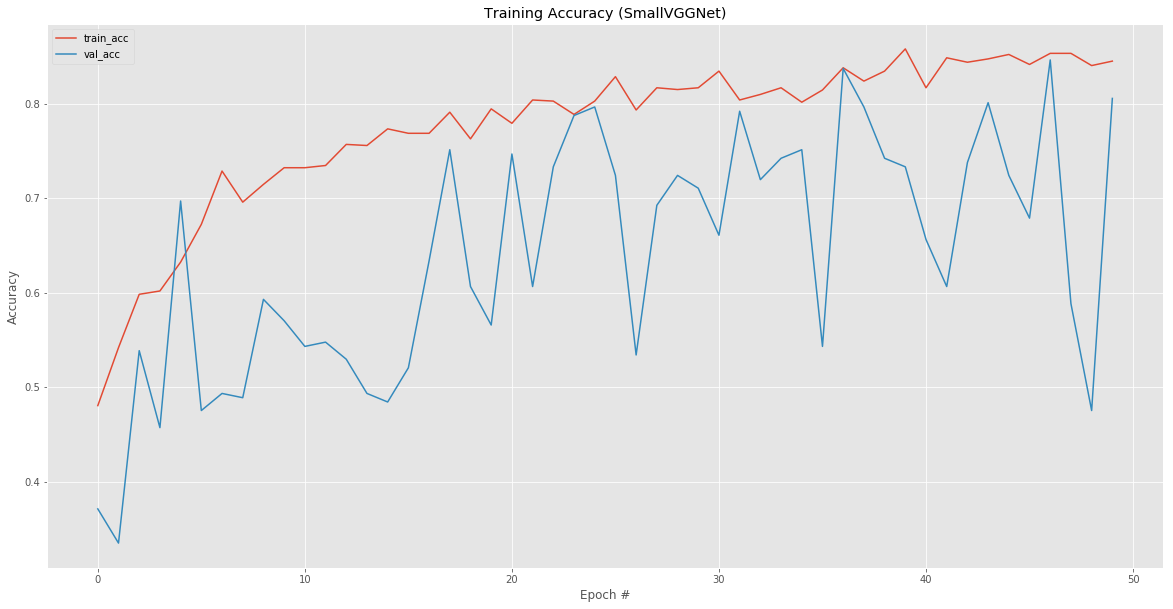

In [27]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("plot3")

In [27]:
# #confusion_matrix precision , recall , f1-score
# from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
# print(classification_report(testY,predictions, target_names=lb.classes_))

In [28]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("model_1")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [13]:
from keras.models import load_model
import argparse
import pickle
import cv2


In [14]:
model = load_model("model_1")
lb = pickle.loads(open("label_bin", "rb").read())

In [23]:
# load weights
model2 = SmallVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.load_weights("weights-improvement-47-0.85.hdf5")
# Compile model (required to make predictions)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss="categorical_crossentropy", optimizer=opt , metrics=["accuracy"])
print("Created model and loaded weights from file")

# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
# estimate accuracy on whole dataset using loaded weights
#scores = model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Created model and loaded weights from file


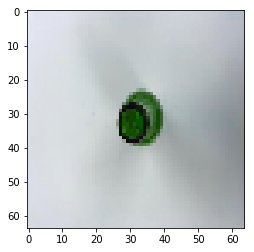

In [24]:
plt.imshow(data[160])

In [25]:
image = data[160]

In [26]:
image = image.reshape((1,image.shape[0], image.shape[1],image.shape[2]))

In [28]:
preds =model2.predict(image)

In [29]:
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]
label

'1'

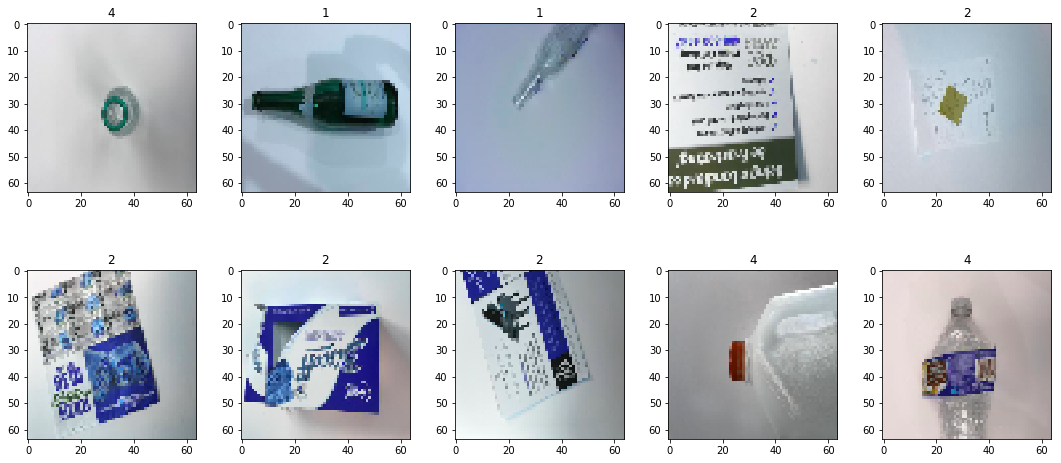

In [33]:
fig , axes = plt.subplots(nrows=2 ,ncols=5 ,figsize=(15,7))
plt.tight_layout()
x = 0 

for i in axes:
    for ax in i:
        x+=90
        ax.imshow(data[x])
        image = data[x]
        image = image.reshape((1,image.shape[0], image.shape[1],image.shape[2]))
        preds =model2.predict(image)
        i = preds.argmax(axis=1)[0]
        label = lb.classes_[i]
        ax.set_title(label)
    
    

In [ ]:
# Glass =1
# Paper =2
# Cardboard =3
# Plastic =4
# Metal =5
# Trach =6

